# Some Preprocessing stuff that needs to be run
# Note: In order to run, follow these steps:
## 1: cmpt419-project/data/ourData has all the .mp4 files
## 2: run video_to_imgseq and video_to_audio

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import os
from pathlib import Path

In [2]:
directory = os.getcwd() + '\\data\\ourData'

In [3]:
data_names = {"name":[], "label":[]}
for folder in sorted(os.listdir(directory)):  
    if (folder[0:5] == "frame"):
        data_names["name"].append(folder)
        data_names["label"].append(folder.split("_")[2][0:4])

In [4]:
data_names_df = pd.DataFrame.from_dict(data_names)
data_names_df

,name,label
0,frames_eric_excitement1,exci
1,frames_eric_excitement10,exci
2,frames_eric_excitement11,exci
3,frames_eric_excitement12,exci
4,frames_eric_excitement2,exci
...,...,...
198,frames_trevor_rage5,rage
199,frames_trevor_rage6,rage
200,frames_trevor_rage7,rage
201,frames_trevor_rage8,rage


In [5]:
data_names_df.groupby(['label'])['label'].count()

label
exci    51
fear    48
frus    17
rage    87
Name: label, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_names_df["name"], data_names_df["label"], test_size=0.3, random_state=2)

In [7]:
to_test = X_test.sort_values(ascending=True)

In [8]:
to_test

2      frames_eric_excitement11
3      frames_eric_excitement12
5       frames_eric_excitement3
6       frames_eric_excitement4
9       frames_eric_excitement7
                 ...           
185        frames_trevor_rage11
190        frames_trevor_rage16
194         frames_trevor_rage2
196         frames_trevor_rage3
202         frames_trevor_rage9
Name: name, Length: 61, dtype: object

In [9]:
X_train

24       frames_eric_frustration3
94           frames_sepehr_fear12
106           frames_sepehr_fear5
8         frames_eric_excitement6
178    frames_trevor_frustration3
                  ...            
43             frames_eric_rage20
22      frames_eric_frustration10
72              frames_eric_rage9
15              frames_eric_fear4
168           frames_trevor_fear2
Name: name, Length: 142, dtype: object

In [10]:
to_test.to_csv('test_data.csv', index=False) 

# Training Model Starts Here

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchaudio.transforms import MelSpectrogram

from utility.data_loader import EmotionDataset
from utility.models import VideoCNN, AudioCNN
from utility.fusion import LateFusion

In [12]:
root_dir = 'data/train' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((112, 112)), #resize should happen before ToTensor.
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

audio_transform = MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=512, n_mels=64)

dataset = EmotionDataset(root_dir, transform=transform, audio_transform=audio_transform)
print(len(dataset))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

107


In [13]:
video_model = VideoCNN(num_classes=2).to(device)
audio_model = AudioCNN(num_classes=2).to(device)
fusion_model = LateFusion(num_classes=2, fusion_type='mlp').to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    list(video_model.parameters()) +
    list(audio_model.parameters()) +
    list(fusion_model.parameters()),
    lr=1e-4
)

# training
num_epochs = 20
for epoch in range(num_epochs):
    video_model.train()
    audio_model.train()
    fusion_model.train()

    total_loss = 0
    correct = 0
    total = 0

    for spectrograms, frames, labels in dataloader:
        spectrograms = spectrograms.to(device)
        frames = frames.to(device)
        
        # label values
        # print("Batch label values:", labels)
        # print("Unique:", labels.unique())

        labels = labels.long().to(device)  # Ensure correct type

        optimizer.zero_grad()

        video_logits = video_model(frames)           
        audio_logits = audio_model(spectrograms)     
        fused_logits = fusion_model(video_logits, audio_logits)  

        loss = criterion(fused_logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(fused_logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f} | Acc: {acc:.2f}%")

C:\Users\ericw\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ericw\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\ericw\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 1/20 | Loss: 3.3164 | Acc: 48.60%
Epoch 2/20 | Loss: 5.7304 | Acc: 60.75%
Epoch 3/20 | Loss: 2.9563 | Acc: 64.49%
Epoch 4/20 | Loss: 5.1392 | Acc: 64.49%
Epoch 5/20 | Loss: 2.3156 | Acc: 72.90%
Epoch 6/20 | Loss: 2.2153 | Acc: 72.90%
Epoch 7/20 | Loss: 2.0781 | Acc: 77.57%
Epoch 8/20 | Loss: 2.1691 | Acc: 68.22%
Epoch 9/20 | Loss: 3.0365 | Acc: 68.22%
Epoch 10/20 | Loss: 2.4589 | Acc: 77.57%
Epoch 11/20 | Loss: 1.8690 | Acc: 76.64%
Epoch 12/20 | Loss: 1.9943 | Acc: 74.77%
Epoch 13/20 | Loss: 2.5030 | Acc: 84.11%
Epoch 14/20 | Loss: 1.8801 | Acc: 74.77%
Epoch 15/20 | Loss: 1.4672 | Acc: 87.85%
Epoch 16/20 | Loss: 2.0163 | Acc: 83.18%
Epoch 17/20 | Loss: 1.3988 | Acc: 85.98%
Epoch 18/20 | Loss: 1.4313 | Acc: 81.31%
Epoch 19/20 | Loss: 1.1329 | Acc: 91.59%
Epoch 20/20 | Loss: 1.2087 | Acc: 87.85%


In [14]:
# save the model if you want

torch.save({
    'video_model': video_model.state_dict(),
    'audio_model': audio_model.state_dict(),
    'fusion_model': fusion_model.state_dict()
}, "rage_detection_fusion_train.pt")


 Evaluation Metrics:
Accuracy     : 0.9907
Precision    : 0.9800
Recall       : 1.0000
F1-score     : 0.9899


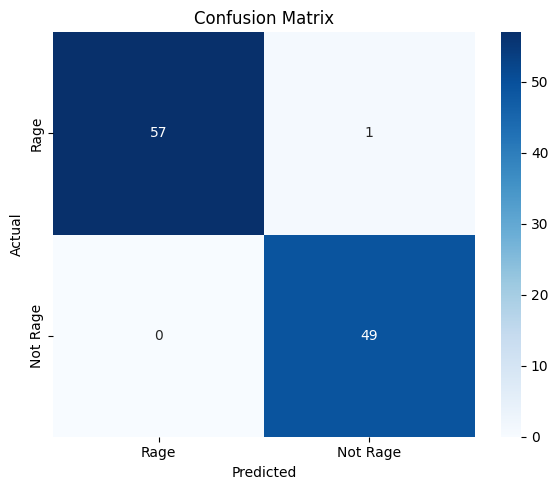

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(video_model, audio_model, fusion_model, dataloader, device):
    video_model.eval()
    audio_model.eval()
    fusion_model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for spectrograms, frames, labels in dataloader:
            spectrograms = spectrograms.to(device)
            frames = frames.to(device)
            labels = labels.to(device)

            video_logits = video_model(frames)
            audio_logits = audio_model(spectrograms)
            fused_logits = fusion_model(video_logits, audio_logits)

            predictions = torch.argmax(fused_logits, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n Evaluation Metrics:")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1-score     : {f1:.4f}")

    # plot the confusion matrix
    class_names = ["Rage", "Not Rage"]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

evaluate_model(video_model, audio_model, fusion_model, dataloader, device)

# Testing Model Starts Here

In [16]:
root_dir = 'data/test' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((112, 112)), #resize should happen before ToTensor.
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

audio_transform = MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=512, n_mels=64)

dataset = EmotionDataset(root_dir, transform=transform, audio_transform=audio_transform)
print(len(dataset))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

45


In [17]:
video_model = VideoCNN(num_classes=2).to(device)
audio_model = AudioCNN(num_classes=2).to(device)
fusion_model = LateFusion(num_classes=2, fusion_type='mlp').to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    list(video_model.parameters()) +
    list(audio_model.parameters()) +
    list(fusion_model.parameters()),
    lr=1e-4
)

# training
num_epochs = 20
for epoch in range(num_epochs):
    video_model.train()
    audio_model.train()
    fusion_model.train()

    total_loss = 0
    correct = 0
    total = 0

    for spectrograms, frames, labels in dataloader:
        spectrograms = spectrograms.to(device)
        frames = frames.to(device)
        
        # label values
        # print("Batch label values:", labels)
        # print("Unique:", labels.unique())

        labels = labels.long().to(device)  # ensure correct type

        optimizer.zero_grad()

        video_logits = video_model(frames)           
        audio_logits = audio_model(spectrograms)     
        fused_logits = fusion_model(video_logits, audio_logits)  

        loss = criterion(fused_logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(fused_logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f} | Acc: {acc:.2f}%")

C:\Users\ericw\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ericw\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\ericw\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 1/20 | Loss: 1.4582 | Acc: 55.56%
Epoch 2/20 | Loss: 1.5415 | Acc: 68.89%
Epoch 3/20 | Loss: 1.1325 | Acc: 66.67%
Epoch 4/20 | Loss: 1.4672 | Acc: 64.44%
Epoch 5/20 | Loss: 1.2044 | Acc: 77.78%
Epoch 6/20 | Loss: 1.1160 | Acc: 80.00%
Epoch 7/20 | Loss: 1.7441 | Acc: 68.89%
Epoch 8/20 | Loss: 1.2675 | Acc: 77.78%
Epoch 9/20 | Loss: 0.9545 | Acc: 84.44%
Epoch 10/20 | Loss: 2.0947 | Acc: 86.67%
Epoch 11/20 | Loss: 1.0845 | Acc: 82.22%
Epoch 12/20 | Loss: 0.8837 | Acc: 88.89%
Epoch 13/20 | Loss: 2.0102 | Acc: 71.11%
Epoch 14/20 | Loss: 1.9465 | Acc: 66.67%
Epoch 15/20 | Loss: 3.5170 | Acc: 77.78%
Epoch 16/20 | Loss: 0.9050 | Acc: 84.44%
Epoch 17/20 | Loss: 2.1823 | Acc: 86.67%
Epoch 18/20 | Loss: 0.8637 | Acc: 80.00%
Epoch 19/20 | Loss: 0.8241 | Acc: 95.56%
Epoch 20/20 | Loss: 0.7560 | Acc: 88.89%


In [18]:
# save the model if you want

torch.save({
    'video_model': video_model.state_dict(),
    'audio_model': audio_model.state_dict(),
    'fusion_model': fusion_model.state_dict()
}, "rage_detection_fusion_test.pt")


 Evaluation Metrics:
Accuracy     : 0.8889
Precision    : 1.0000
Recall       : 0.6875
F1-score     : 0.8148


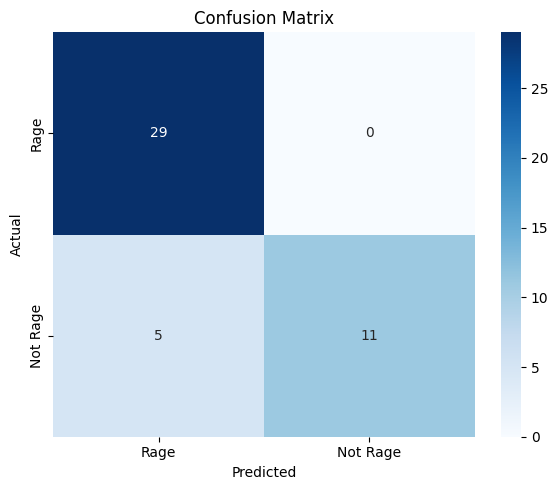

In [19]:
def evaluate_model(video_model, audio_model, fusion_model, dataloader, device):
    video_model.eval()
    audio_model.eval()
    fusion_model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for spectrograms, frames, labels in dataloader:
            spectrograms = spectrograms.to(device)
            frames = frames.to(device)
            labels = labels.to(device)

            video_logits = video_model(frames)
            audio_logits = audio_model(spectrograms)
            fused_logits = fusion_model(video_logits, audio_logits)

            predictions = torch.argmax(fused_logits, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n Evaluation Metrics:")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1-score     : {f1:.4f}")

    # plot the confusion matrix
    class_names = ["Rage", "Not Rage"]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

evaluate_model(video_model, audio_model, fusion_model, dataloader, device)